#   Chronic Disease Risk Analysis Using Healthcare Survey Data

This project analyzes healthcare survey data to understand the factors that increase the risk of chronic diseases. The goal is to identify key risk drivers such as age, smoking, body mass index (BMI), and physical activity, and to demonstrate how machine learning can support population health analysis.

In [ ]:

import pandas as pd
import pyreadstat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

### Data Description

The dataset is derived from a large healthcare survey and includes demographic information (age, gender), Lifestyle factors (smoking status, physical activity), Health measurements (BMI), Chronic disease indicators (diabetes, asthma, heart disease, etc.) Survey response codes were cleaned and standardized, threshold was set at 75% to ensure completeness. This ensures that only confirmed medical conditions were included in the analysis.

In [12]:
df=pd.read_csv(r"D:\Projects\Heatlthcare\LLCP2024.csv")

threshold = 0.75
non_null = int(len(df) * threshold)

df_raw = df.dropna(axis=1, thresh=non_null)

df_raw.to_csv(r"D:\Projects\Heatlthcare\LLCP2024_raw.csv", index=False)
df_raw=pd.read_csv(r"D:\Projects\Heatlthcare\LLCP2024_raw.csv")

### Relevant feature (Reduction with corr_matrix filtering)

Correlation analysis was used to identify relationships between variables and reduce the number of features. A correlation matrix and heatmap were created to visually inspect strong positive and negative relationships. The matrix was then unstacked to evaluate individual variable pairs. Self-correlations were removed, and only pairs above a defined correlation threshold were retained. Unique variables from these pairs were selected to form a reduced dataset. This helped eliminate weak features, reduce noise, and focus the analysis on the most relevant variables.

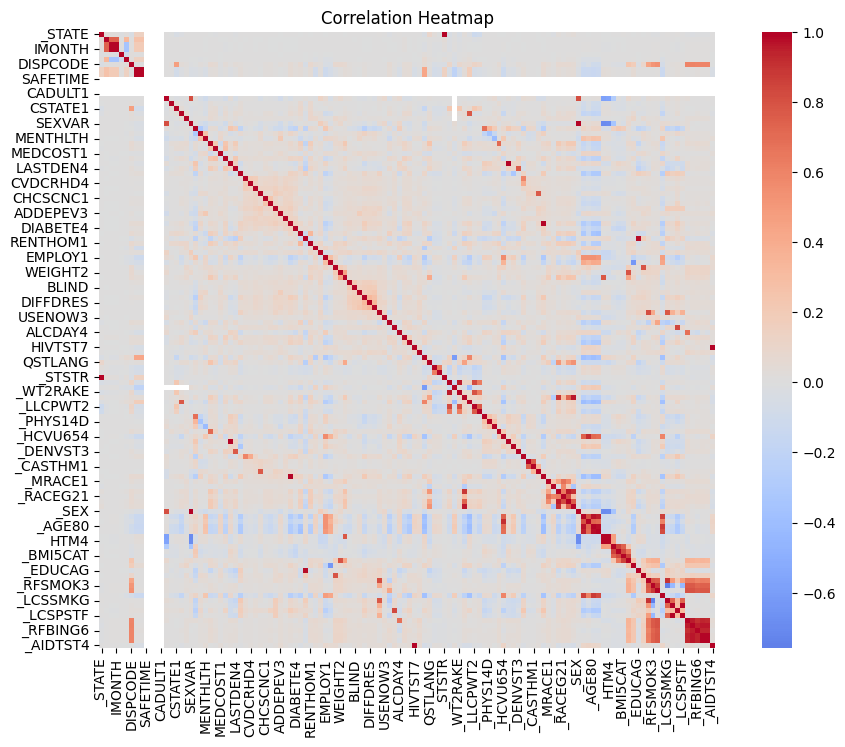

In [13]:
corr_matrix = df_raw.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Correlation Heatmap")
plt.show()

corr_matrix_filter = df_clean.corr()
corr_pairs = corr_matrix_filter.unstack()
corr_pairs = corr_pairs[corr_pairs != 1]
high_corr = corr_pairs[corr_pairs.abs() > 0.1]

high_corr_df = high_corr.reset_index()
high_corr_df.columns = ['Var1', 'Var2', 'Corr']

# Extracted unique features
features = pd.unique(
    high_corr_df[['Var1', 'Var2']].values.ravel()
)

final_df = df[list(features)].copy()
final_df['Employee_Count'] = 1

final_df.to_csv(r"D:\Projects\Heatlthcare\Healthcare_dataset_filtered.csv", index=False)


### Feature encoding and engineering for modelling

The dataset was cleaned and prepared by converting chronic condition variables into binary indicators, where only confirmed diagnoses were counted. Survey response codes for physical activity and smoking status were simplified into clear binary categories. A chronic condition count and a normalized chronic score was created to measure overall disease intensity. BMI values were scaled to standard units and grouped into a meaningful BMI categories. A coloumn was added to identify individuals with at least one chronic condition. The final cleaned and encoded dataset was saved for later use in modeling and visualization.

In [21]:
df_filtered=pd.read_csv(r"D:\Projects\Heatlthcare\Healthcare_dataset_filtered.csv")


chronic_cols = [

    'CVDINFR4',
    'CVDCRHD4',
    'CVDSTRK3',
    'ASTHMA3',
    'CHCSCNC1',
    'CHCOCNC1',
    'CHCCOPD3',
    'ADDEPEV3',
    'CHCKDNY2',
    'HAVARTH4'
]


for col in chronic_cols:
    df_filtered[col] = df_filtered[col].apply(lambda x: 1 if x == 1 else 0)


df_filtered['EXERANY2'] = df_filtered['EXERANY2'].replace({1:1, 2:0, 7:0, 9:0})

df_filtered['Smoker'] = df_filtered['_SMOKER3'].replace({1:1, 2:1, 3:1, 4:0, 9:0})

df_filtered['CHRONIC_COUNT'] = df_filtered[chronic_cols].sum(axis=1)

df_filtered['CHRONIC_SCORE'] = df_filtered['CHRONIC_COUNT'] / len(chronic_cols)
df_filtered['_BMI5'] = df_filtered['_BMI5'] / 100

df_filtered['HAS_CHRONIC'] = np.where(df_filtered['CHRONIC_COUNT'] >= 1, 1, 0)

df_filtered['BMI_BAND'] = pd.cut(
    df_filtered['_BMI5'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

df_filtered.to_csv(r"D:\Projects\Heatlthcare\Master_reference_backup\Encoded_Healthcare_Dataset.csv", index=False)

df_explore=pd.read_csv(r"D:\Projects\Heatlthcare\Master_reference_backup\Encoded_Healthcare_Dataset.csv")


print(df_explore.groupby('Smoker')['CHRONIC_SCORE'].mean())

print(df_explore[df_explore['Smoker'] == 1].groupby(pd.cut(df_explore['_BMI5'], [0, 18.5, 25, 30, 100]), observed=True)['CHRONIC_SCORE'].mean())

print(df_explore.groupby(['Smoker','EXERANY2'])['CHRONIC_SCORE'].mean())


features = [
    'Smoker',
    '_BMI5',
    'EXERANY2', 
    '_AGE80',
]

target = 'HAS_CHRONIC'

df_modelling_set = df_explore[features + [target]].dropna()

df_modelling_set.to_csv(r"D:\Projects\Heatlthcare\Master_reference_backup\Modelling_Healthcare_Dataset.csv", index=False)



Smoker
0.0    0.101004
1.0    0.157870
Name: CHRONIC_SCORE, dtype: float64
_BMI5
(0.0, 18.5]      0.179202
(18.5, 25.0]     0.146816
(25.0, 30.0]     0.150848
(30.0, 100.0]    0.174468
Name: CHRONIC_SCORE, dtype: float64
Smoker  EXERANY2
0.0     0.0         0.131492
        1.0         0.092943
1.0     0.0         0.202665
        1.0         0.140409
Name: CHRONIC_SCORE, dtype: float64


### Model Training & evaluating 

The features which were selected were separated into input variables and a target variable. The data was split into training and testing sets to evaluate model performance on unseen data. We ran a logistic regression model which is trained to predict the presence of chronic conditions. Model performance was evaluated using accuracy, classification metrics, a confusion matrix, and an ROC curve to assess prediction quality and class separation.

Accuracy: 0.6798414015319608
              precision    recall  f1-score   support

           0       0.61      0.39      0.48     38493
           1       0.70      0.85      0.77     65165

    accuracy                           0.68    103658
   macro avg       0.65      0.62      0.62    103658
weighted avg       0.67      0.68      0.66    103658



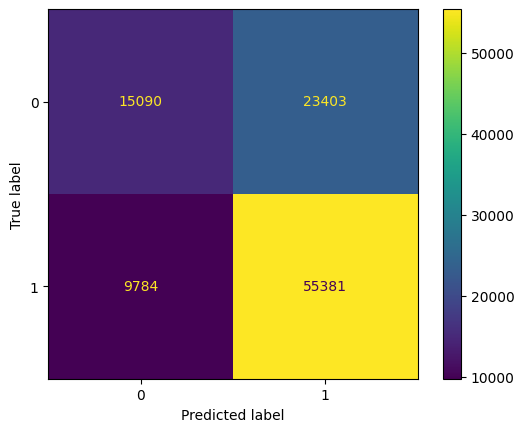

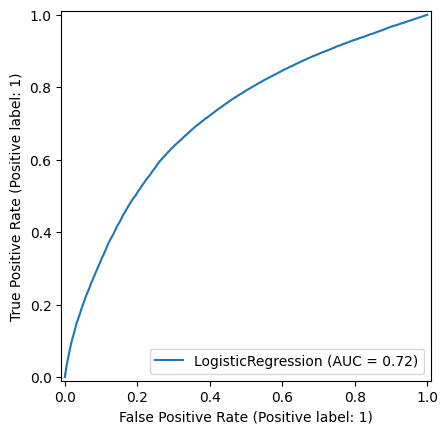

In [10]:

X = df_modelling_set[features]
y = df_modelling_set[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred = log_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


ConfusionMatrixDisplay.from_estimator(
    log_model, X_test_scaled, y_test
)
plt.show()

RocCurveDisplay.from_estimator(
    log_model, X_test_scaled, y_test
)
plt.show()



### Impact of feature using Odds Ratios

This step shows how each feature is influencing the risk of chronic disease. Logistic regression coefficients were converted into odds ratios to make. Odds ratios greater than one indicate increased risk, while values below one indicate a protective effect. The bar chart will visualize the relative impact of each feature, with the red reference line showing no effect on risk.

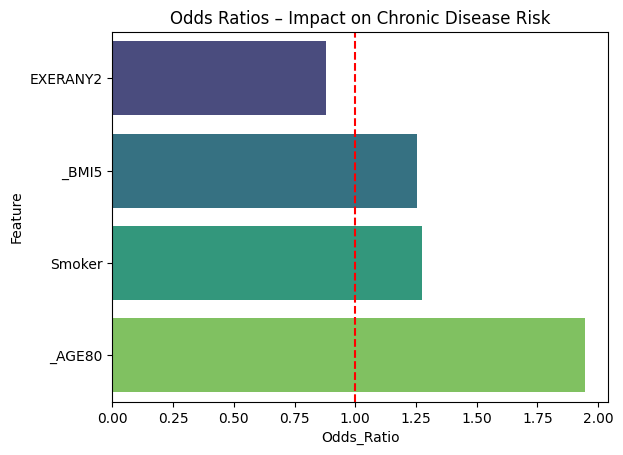

In [18]:


coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Beta_Coefficient': log_model.coef_[0]
})

coeff_df['Odds_Ratio'] = np.exp(coeff_df['Beta_Coefficient'])
coeff_df.sort_values(by='Odds_Ratio', ascending=False)

sns.barplot(
    x='Odds_Ratio',
    y='Feature',
    hue='Feature',
    data=coeff_df.sort_values('Odds_Ratio'),
    palette='viridis',
    legend=False
)

plt.axvline(1, color='red', linestyle='--')
plt.title("Odds Ratios – Impact on Chronic Disease Risk")
plt.show()

## Results & Interpretation

Age is the strongest factor influencing chronic disease risk. As age increases, the likelihood of developing chronic conditions rises sharply. The odds ratio of approximately 1.95 indicates that older individuals have nearly double the risk of having a chronic disease compared to younger individuals.

Smoking is also a significant risk factor. With an odds ratio of about 1.25, smokers have around 25% higher chances of developing chronic conditions than non-smokers. This effect remains strong even after accounting for age and BMI, showing that smoking independently increases health risk.

Body Mass Index (BMI) shows a clear positive relationship with chronic disease risk. An odds ratio of approximately 1.22 means that each increase in BMI category raises the risk by about 22%. This highlights the strong association between higher body weight and chronic health conditions.

Physical activity is the only factor that reduces risk in this analysis. With an odds ratio of around 0.85, physically active individuals have about 15% lower odds of developing chronic disease compared to inactive individuals. This indicates that regular physical activity plays an important protective role, even in populations with other risk factors.
